## Camera Sticker App

In [1]:
## Import modules
import os, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import pdb

In [2]:
## get face landmark model
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [3]:
## get image files
my_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image*.jpg'
file_names=[]
for file in glob.iglob(my_path):
    file_names= np.append(file_names, file)
file_names = np.sort(file_names)    

In [4]:
## get sticker file
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'

In [5]:
def sticker_app(my_image_path):
    try:
        img_show, img_bgr, img_rgb = load_image(my_image_path)
        img_show_rgb, dlib_rects = face_detection(img_show, img_rgb)
        list_landmarks = get_landmarks(img_show,img_show_rgb, img_rgb, dlib_rects)
        x, y, w, h = sticker_location(dlib_rects, list_landmarks)
        img_sticker = attach_sticker(x, y, w, h, img_show, img_bgr)
    except IndexError:
        print('Face Not Detected!')
        print('bounding box: ', dlib_rects)

In [6]:
def load_image(my_image_path):
    img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
    Y= int(img_bgr.shape[0] / 4)
    X= int(img_bgr.shape[1] / 4)
    img_bgr = cv2.resize(img_bgr, (X, Y))    #  각 이미지의 비율에 맞게 resize
    img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) ## convert BGR to RGB
    print(my_image_path)
    plt.imshow(img_rgb)
    plt.show()
    return img_show, img_bgr, img_rgb

In [7]:
def face_detection(img_show, img_rgb):
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
    dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
    if dlib_rects==None:
        pdb.set_trace()
    print(dlib_rects)   # 찾은 얼굴영역 좌표
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    return img_show_rgb, dlib_rects

In [8]:
def get_landmarks(img_show, img_show_rgb, img_rgb, dlib_rects):
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    return list_landmarks ##img_show_rgb

In [9]:
def sticker_location(dlib_rects, list_landmarks):
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] - dlib_rect.width()//4
        y = landmark[30][1] - dlib_rect.height()//4
        w = dlib_rect.width() //2
        h = dlib_rect.height() //2
        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
    return x, y, w, h

In [10]:
def attach_sticker(x, y, w, h, img_show, img_bgr):
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    print (img_sticker.shape)
    
    refined_x = x
    refined_y = y
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_sticker

#### 정면 사진

/aiffel/aiffel/camera_sticker/images/image00.jpg


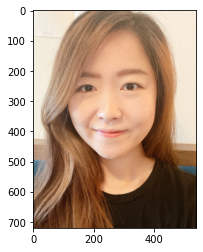

rectangles[[(98, 170) (419, 491)]]


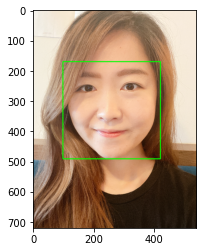

68


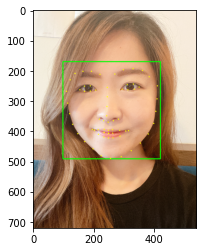

(x,y) : (162,269)
(w,h) : (161,161)
(161, 161, 3)
(x,y) : (162,269)


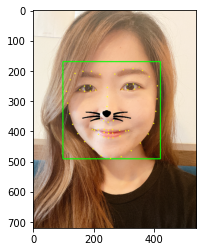

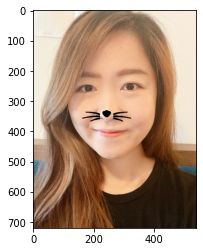

In [11]:
sticker_app(file_names[0])
# for file_name in file_names:
#     add_sticker(file_name)

## 회고

### 사용한 데이터
- 셀카로 정면 및 옆 방향에서 찍은 사진을 사용하였다.
- 추가적으로 모자, 마스크, 선글래스 착용샷과 셀카보다 멀리서 찍은 사진을 사용하여 비교분석 하였다.

### 진행 방향
- dlib의 face detector 를 이용하여 각 이미지에서 HOG 패턴에서 얼굴을 검출하고, 검출된 얼굴 이미지에서 top-down 방식으로 bounding box 를 찾는 형식으로 얼굴의 key points 68개를 찾았다. 여기서는 그 중 스티커를 붙일 좌표를 계산하기 가장 알맞은 코의 좌표 ([30])을 사용하였다.
- 스티커는 bounding box의 절반 사이즈로 조절하였고, 스티커의 코 부분이 얼굴의 코와 맞춰져야 하므로 스티커의 top-left 좌표 (x, y) 는 [30] 의 좌표로부터 스티커의 절반 사이즈만큼 이동하였다. (bounding box / 4)
- original 사진의 x 와 y 좌표에서 각각 스티커의 크기만큼 까지를 sticker_area 로 선정, 그 중 스티커의 검정색 부분만 기존 사진에 추가 되도록 값을 변경 하여 사용했다.

### Analysis
- 가장 어렵고 시간이 걸렸던 것이 좌표를 정확히 맞추는 것이었는데, 간단하게 [30] 좌표를 쓰면서 해결이 되었다.
- 스티커는 top-left 코너의 좌표를 지정하여 원본 사진에 붙이는 방식으로 구현되어 있으므로 현재 코드에서는 기울여지지 않은 정면사진만을 사용하여야 할 것으로 보인다. 다만, 이 좌표를 쓰면서 눈 혹은 다른 얼굴 좌표를 사용하여 기울여진 사진에 맞추어 스티커를 tilt 해주면 어느정도 기울어진 사진에서도 잘 붙을 것으로 생각 된다. - 이 또한 왜곡된 사진에서는 사용할 수 없을 것이다.
- 같은 사진이라도 너무 작게 리사이징 되면 화질이 낮아 인식이 불가능하여 조금 크게 리사이징 할 필요가 있었다.
- (갑자기 궁금해져서..) 추가적으로 화질이 안좋은 사진과 동물 사진으로 해보았으나 예상했던대로 인식이 되지 않았다.

### Results
- 모자와 안경을 착용한 사진에서는 HOG 패턴이 잘 검출되는것을 볼 수 있었으나, 멀리서 찍은 사진이나 마스크, 선글래스 착용한 부분에서는 어느정도의 오차가 있음을 볼 수 있다. 빛의 패턴을 detect 하는 방식이므로 선글래스의 반사되는 부분이나 마스크의 형태 등으로 인하여 오차가 생긴 것으로 보인다. 그러나 어느정도 인식이 되어 재미를 위한 스티커 앱 용으로는 사용가능할 것으로 보인다.
- 스티커 앱은 사용자가 즉각적으로 확인할 수 있어야 하므로 어느정도의 속도개선이 필요하다.
- 또한, 사용자의 재미를 위한 앱이라면 100%의 정확도가 필요하진 않지만 어느정도 잘 된다고 느껴야 지속적으로 사용할 것이므로 위에서 서술한대로 기울기 정도의 기능은 넣어주면 좋을 것으로 보인다. 코 좌표 외에 추가적으로 양쪽 눈 혹은 양쪽 볼 좌표 등 대칭되는 좌표를 이용하여 개선해봐야 하겠다.